## Met Office COVID-19 response dataset

This dataset is created, curated and updated for researchers looking to understand links between COVID-19 and environmental factors. 

For more information check out our [blog post](https://medium.com/informatics-lab/met-office-and-partners-offer-data-and-compute-platform-for-covid-19-researchers-83848ac55f5f) and the [data readme](https://metdatasa.blob.core.windows.net/covid19-response/README_data.html).

We are constantly updating the available data; [subscribe to our news group](https://groups.google.com/forum/#!forum/met-office-covid-19-data-and-platform-updates/join) to stay up to date or [contact us](mailto:covid19@informaticslab.co.uk) if you have any requests or questions.

## Imports and globals
Import the required modules, set up the default plot size and set some constants

In [2]:
import matplotlib.pyplot as plt 
import datetime

from azure.storage.blob import BlobClient, ContainerClient
from IPython.display import Markdown
from collections import namedtuple

plt.rcParams['figure.figsize'] = (20.0, 10.0)

## Set up the blob client with the connection details

In [3]:
account_url  = 'https://metdatasa.blob.core.windows.net/'
container_name = 'covid19-response'

# Create the ContainerClient object which will be used to enumerate blobs
container_client = ContainerClient(account_url=account_url,
                                   container_name=container_name,
                                   credential=None)

## List the files under metoffice_global_daily/t1o5m_max

In [4]:
max_blobs = 10
for i_blob,blob in enumerate(container_client.list_blobs(
    name_starts_with='metoffice_global_daily/t1o5m_max')):
    print(f'{blob.name}')
    if i_blob >= max_blobs:
        break

metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200101.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200102.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200103.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200104.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200105.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200106.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200107.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200108.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200109.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200110.nc
metoffice_global_daily/t1o5m_max/global_daily_t1o5m_max_20200111.nc


## Get a particular file based on the data required

In [5]:
data_end = (datetime.datetime.now() - datetime.timedelta(days=9)).date()
data_start = datetime.date(2020,1,1)

def url_from_properties(model, param, freq, stat=None, day=None, hour=None):
    
    assert model in ["global","ukv"]
    assert param in ["rain", "sh", "snow", "t1o5m", "pmsl","precip","sw"]
    assert freq in ["daily","hourly"]
    if freq == 'daily':
        assert stat in ['max', 'min', 'mean']
    else:
        assert stat is None  
    assert data_start <= day <= data_end
    
    stat = '_'+stat if stat else ''

    filepath = f'metoffice_{model}_{freq}/{param}{stat}/{model}_{freq}_{param}{stat}_{day:%Y%m%d}.nc'
    return f"{account_url}/{container_name}/{filepath}"

Properties = namedtuple('Properties',["model","param","freq","stat","day"])

files = [
    Properties("global","precip","daily","mean",datetime.date(2020,3,3)),
    Properties("ukv","t1o5m","daily","min",datetime.date(2020,4,1)),
    Properties("ukv","snow","hourly",None,datetime.date(2020,2,2)),
]

for file in files:
    path = url_from_properties(*file)
    print(path.replace(account_url,''))

/covid19-response/metoffice_global_daily/precip_mean/global_daily_precip_mean_20200303.nc
/covid19-response/metoffice_ukv_daily/t1o5m_min/ukv_daily_t1o5m_min_20200401.nc
/covid19-response/metoffice_ukv_hourly/snow/ukv_hourly_snow_20200202.nc


## xarray and iris are useful tools for interacting with this sort of data

In [8]:
import xarray as xr
import iris
from io import BytesIO

## Stream blob into memory and load dataset in xarray

In [10]:
data_description = Properties("global","precip","daily","mean",datetime.date(2020,1,30))
file_data = BytesIO(BlobClient.from_blob_url(
    url_from_properties(*data_description)).download_blob().readall())
ds = xr.open_dataset(file_data)
ds

/home/dmorris/anaconda3/lib/python3.7/site-packages/h5netcdf/core.py:765: FutureWarning: String decoding changed with h5py >= 3.0. Currently backwards compatibility with h5py < 3.0 is kept by decoding vlen strings per default. This will change in future versions for consistency with h5py >= 3.0. Setting 'decode_vlen_strings=True' forces string decoding.
  warnings.warn(msg, FutureWarning, stacklevel=0)


<xarray.Dataset>
Dimensions:                       (bnds: 2, latitude: 1920, longitude: 2560)
Coordinates:
  * latitude                      (latitude) float32 -89.95 -89.86 ... 89.95
  * longitude                     (longitude) float32 0.07031 0.2109 ... 359.9
    forecast_period               timedelta64[ns] ...
    forecast_reference_time       datetime64[ns] ...
    time                          datetime64[ns] ...
Dimensions without coordinates: bnds
Data variables:
    precipitation_flux            (latitude, longitude) float32 ...
    latitude_longitude            int32 ...
    forecast_period_bnds          (bnds) float64 ...
    forecast_reference_time_bnds  (bnds) datetime64[ns] ...
    time_bnds                     (bnds) datetime64[ns] ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   11.2
    Conventions:  CF-1.5

## Plot it with iris

<iris 'Cube' of m01s01i202 / (unknown) (time: 24; grid_latitude: 808; grid_longitude: 621)>

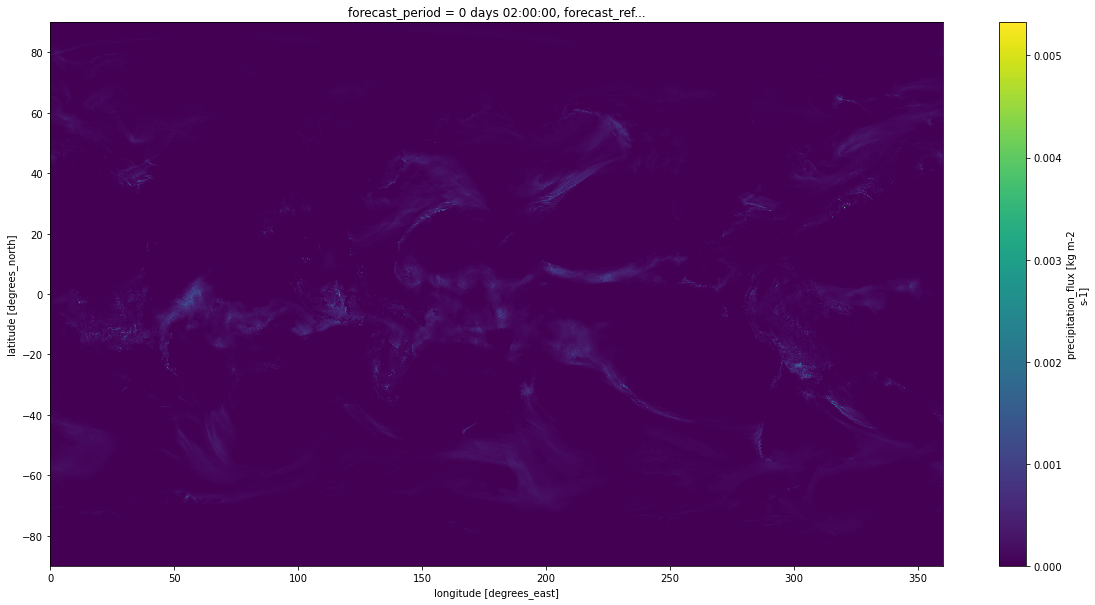

In [11]:
import tempfile

ds.precipitation_flux.plot()

tmp = tempfile.NamedTemporaryFile(delete=False)
data_description = Properties("ukv","sw","hourly",None,datetime.date(2020,1,30))
tmp.write(BlobClient.from_blob_url(
    url_from_properties(*data_description)).download_blob().readall())
local_path = tmp.name
tmp.close()

sw = iris.load_cube(local_path)
sw